In [ ]:
# dataset preparation

# getting the longitude and latitude 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv ("OSUN_crosschecked_geocoded.csv")

df.columns 

Index(['State', 'LGA', 'Ward', 'PU-Code', 'PU-Name', 'Accredited_Voters',
       'Registered_Voters', 'Results_Found', 'Transcription_Count',
       'Result_Sheet_Stamped', 'Result_Sheet_Corrected',
       'Result_Sheet_Invalid', 'Result_Sheet_Unclear', 'Result_Sheet_Unsigned',
       'APC', 'LP', 'PDP', 'NNPP', 'Results_File', 'Latitude', 'Longitude'],
      dtype='object')

In [3]:
# Dropping NaN 
data = df.dropna(subset=['Longitude', 'Latitude'])

In [4]:
data

,State,LGA,Ward,PU-Code,PU-Name,Accredited_Voters,Registered_Voters,Results_Found,Transcription_Count,Result_Sheet_Stamped,...,Result_Sheet_Invalid,Result_Sheet_Unclear,Result_Sheet_Unsigned,APC,LP,PDP,NNPP,Results_File,Latitude,Longitude
0,OSUN,ATAKUMOSA EAST,IWARA,29-01-01-001,TOWN HALL IWARA,181,942,True,-1,False,...,False,False,UNKNOWN,44,273,0,0,https://inec-cvr-cache.s3.eu-west-1.amazonaws....,7.50000,4.50000
1,OSUN,ATAKUMOSA EAST,IWARA,29-01-01-003,"L.A. SCHOOL, IWIKUN",245,881,True,-1,False,...,False,False,UNKNOWN,40,11,175,1,https://inec-cvr-cache.s3.eu-west-1.amazonaws....,7.50000,4.50000
2,OSUN,ATAKUMOSA EAST,IWARA,29-01-01-004,"METHODIST PRY. SCHOOL, AYETORO",117,308,True,-1,False,...,False,False,UNKNOWN,14,3,99,1,https://inec-cvr-cache.s3.eu-west-1.amazonaws....,7.50000,4.50000
3,OSUN,ATAKUMOSA EAST,IWARA,29-01-01-007,OPEN SPACE ODO-IWARA,187,538,True,-1,False,...,False,False,UNKNOWN,25,4,155,0,https://docs.inecelectionresults.net/elections...,7.50000,4.50000
4,OSUN,ATAKUMOSA EAST,IGANGAN,29-01-02-001,"N.U.D PRY. SCHOL, IGANGAN",187,558,True,-1,False,...,False,False,UNKNOWN,22,0,161,0,https://docs.inecelectionresults.net/elections...,7.50000,4.50000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2240,OSUN,OSOGBO,ATAOJA 'E',29-30-05-036,"OPEN SPACE, SALVATION ARMY PRY.SCHOOL CAR PARK...",157,546,True,-1,False,...,False,False,UNKNOWN,0,0,0,0,https://docs.inecelectionresults.net/elections...,0.96675,33.82622
2241,OSUN,OSOGBO,ATAOJA 'E',29-30-05-037,"OPEN SPACE, SALVATION ARMY PRY.SCHOOL CAR PARK...",157,546,True,-1,False,...,False,False,UNKNOWN,2,5,7,0,https://docs.inecelectionresults.net/elections...,0.96675,33.82622
2242,OSUN,OSOGBO,ATAOJA 'E',29-30-05-041,"OPEN SPACE, SALVATION ARMY PRY.SCHOOL CAR PARK...",157,546,True,-1,False,...,False,False,UNKNOWN,50,26,46,0,https://docs.inecelectionresults.net/elections...,0.96675,33.82622
2243,OSUN,OSOGBO,ATAOJA 'E',29-30-05-042,"OPEN SPACE, SALVATION ARMY PRY.SCHOOL CAR PARK...",157,546,True,-1,False,...,False,False,UNKNOWN,25,4,14,2,https://docs.inecelectionresults.net/elections...,0.96675,33.82622


In [5]:
# Neighbour Identification

In [6]:
from geopy.distance import distance

In [7]:
# Function to calculate neighbours
def find_neighbours(data, radius_km=1.0):
    neighbours = {}

    # Iterate over each polling unit
    for index, row in data.iterrows():
        polling_unit_id = row['PU-Code']
        neighbours[polling_unit_id] = []

        # Compare with all other polling units
        for _, neighbor_row in data.iterrows():
            if polling_unit_id != neighbor_row['PU-Code']:
                # Calculate distance between points (latitude, longitude)
                dist_km = distance((row['Latitude'], row['Longitude']),
                                   (neighbor_row['Latitude'], neighbor_row['Longitude'])).km

                # Check if within radius
                if dist_km <= radius_km:
                    neighbours[polling_unit_id].append(neighbor_row['PU-Code'])

    return neighbours

# Calculate neighbours within 1 km radius
neighbours = find_neighbours(data, radius_km=1.0)

In [8]:
# implementing outlier score 

In [16]:

# Function to calculate outlier scores
def calculate_outlier_scores(data, neighbours):
    outlier_scores = []

    # Iterate over each polling unit
    for index, row in data.iterrows():
        polling_unit_id = row['PU-Code']

        # Iterate over each party of interest
        for party in ['APC', 'LP', 'PDP', 'NNPP']:
            votes_current_unit = row[party]
            neighbour_votes = []

            # Get votes of neighbours for the party
            for neighbour_id in neighbours.get(polling_unit_id, []):
                neighbour_row = data[data['PU-Code'] == neighbour_id].iloc[0]
                neighbour_votes.append(neighbour_row[party])

            # Calculate outlier score
            if neighbour_votes:
                mean_neighbour_votes = sum(neighbour_votes) / len(neighbour_votes)
                outlier_score = abs(votes_current_unit - mean_neighbour_votes)
            else:
                outlier_score = 0

            # Append to outlier_scores list
            outlier_scores.append({
                'PollingUnitID': polling_unit_id,
                'Party': party,
                'OutlierScore': outlier_score
            })

    return pd.DataFrame(outlier_scores)

# Calculate outlier scores
outlier_scores = calculate_outlier_scores(data, neighbours)


In [17]:
outlier_scores

,PollingUnitID,Party,OutlierScore
0,29-01-01-001,APC,11.065217
1,29-01-01-001,LP,266.934783
2,29-01-01-001,PDP,104.467391
3,29-01-01-001,NNPP,0.108696
4,29-01-01-003,APC,15.108696
...,...,...,...
8507,29-30-05-042,NNPP,2.000000
8508,29-30-11-019,APC,47.200000
8509,29-30-11-019,LP,11.200000
8510,29-30-11-019,PDP,38.800000


In [18]:
merged_df = data.merge (outlier_scores, left_on = "PU-Code", right_on='PollingUnitID', how='left')

In [19]:
merged_df

,State,LGA,Ward,PU-Code,PU-Name,Accredited_Voters,Registered_Voters,Results_Found,Transcription_Count,Result_Sheet_Stamped,...,APC,LP,PDP,NNPP,Results_File,Latitude,Longitude,PollingUnitID,Party,OutlierScore
0,OSUN,ATAKUMOSA EAST,IWARA,29-01-01-001,TOWN HALL IWARA,181,942,True,-1,False,...,44,273,0,0,https://inec-cvr-cache.s3.eu-west-1.amazonaws....,7.50000,4.50000,29-01-01-001,APC,11.065217
1,OSUN,ATAKUMOSA EAST,IWARA,29-01-01-001,TOWN HALL IWARA,181,942,True,-1,False,...,44,273,0,0,https://inec-cvr-cache.s3.eu-west-1.amazonaws....,7.50000,4.50000,29-01-01-001,LP,266.934783
2,OSUN,ATAKUMOSA EAST,IWARA,29-01-01-001,TOWN HALL IWARA,181,942,True,-1,False,...,44,273,0,0,https://inec-cvr-cache.s3.eu-west-1.amazonaws....,7.50000,4.50000,29-01-01-001,PDP,104.467391
3,OSUN,ATAKUMOSA EAST,IWARA,29-01-01-001,TOWN HALL IWARA,181,942,True,-1,False,...,44,273,0,0,https://inec-cvr-cache.s3.eu-west-1.amazonaws....,7.50000,4.50000,29-01-01-001,NNPP,0.108696
4,OSUN,ATAKUMOSA EAST,IWARA,29-01-01-003,"L.A. SCHOOL, IWIKUN",245,881,True,-1,False,...,40,11,175,1,https://inec-cvr-cache.s3.eu-west-1.amazonaws....,7.50000,4.50000,29-01-01-003,APC,15.108696
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8507,OSUN,OSOGBO,ATAOJA 'E',29-30-05-042,"OPEN SPACE, SALVATION ARMY PRY.SCHOOL CAR PARK...",157,546,True,-1,False,...,25,4,14,2,https://docs.inecelectionresults.net/elections...,0.96675,33.82622,29-30-05-042,NNPP,2.000000
8508,OSUN,OSOGBO,ATAOJA 'E',29-30-11-019,"OPEN SPACE, SALVATION ARMY PRY.SCHOOL CAR PARK...",157,546,True,-1,False,...,65,19,56,0,https://docs.inecelectionresults.net/elections...,0.96675,33.82622,29-30-11-019,APC,47.200000
8509,OSUN,OSOGBO,ATAOJA 'E',29-30-11-019,"OPEN SPACE, SALVATION ARMY PRY.SCHOOL CAR PARK...",157,546,True,-1,False,...,65,19,56,0,https://docs.inecelectionresults.net/elections...,0.96675,33.82622,29-30-11-019,LP,11.200000
8510,OSUN,OSOGBO,ATAOJA 'E',29-30-11-019,"OPEN SPACE, SALVATION ARMY PRY.SCHOOL CAR PARK...",157,546,True,-1,False,...,65,19,56,0,https://docs.inecelectionresults.net/elections...,0.96675,33.82622,29-30-11-019,PDP,38.800000


In [13]:
# Sorting the Dataset by Outlier Scores

# Sorting the outlier scores for each party
sorted_outliers = outlier_scores.sort_values(by=['Party', 'OutlierScore'], ascending=False)

# Save the sorted outlier scores to a CSV file
sorted_outliers.to_csv('sorted_outlier_scores.csv', index=False)

# Display the top 10 outliers for inspection
print(sorted_outliers.head(10))


     PollingUnitID Party  OutlierScore
1430  29-07-05-004   PDP    249.020619
7022  29-26-07-001   PDP    228.000000
7026  29-26-07-002   PDP    228.000000
4210  29-17-04-013   PDP    222.811765
4170  29-17-03-007   PDP    188.411765
8318  29-08-04-008   PDP    173.382979
1426  29-07-05-003   PDP    172.237113
1690  29-08-04-006   PDP    164.659574
1694  29-08-05-001   PDP    164.659574
1742  29-08-07-003   PDP    164.659574


In [ ]:
# Sorting the Dataset by Outlier Scores

# Sorting the outlier scores for each party
sorted_outliers = merged_df.sort_values(by=['Party', 'OutlierScore'], ascending=False)

# Save the sorted outlier scores to a CSV file
sorted_outliers.to_csv('sorted_outlier_scores.csv', index=False)

# Display the top 10 outliers for inspection
print(sorted_outliers.head(10))


In [ ]:
sorted_outliers

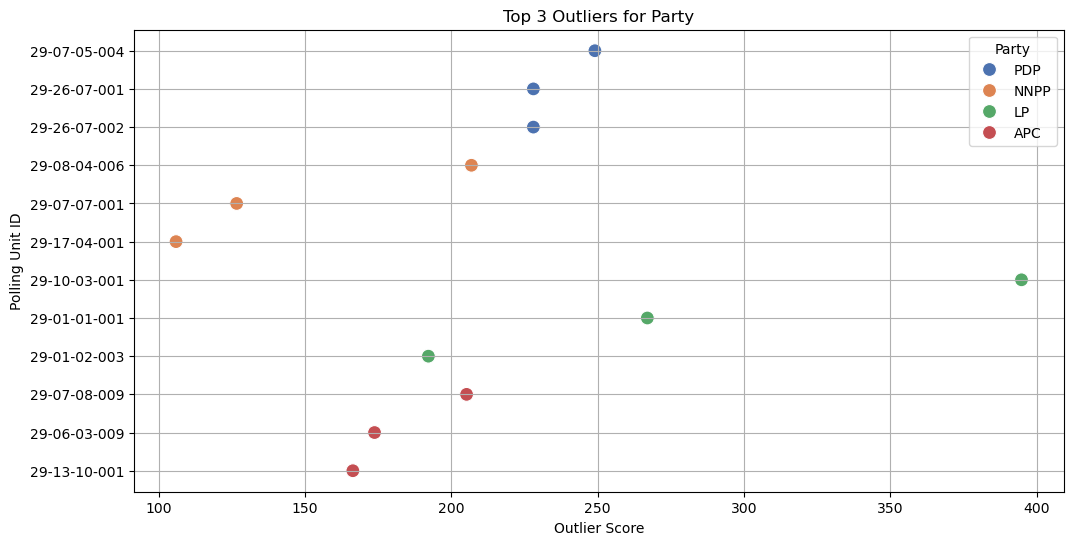

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get top 10 outliers for each party
top_outliers = sorted_outliers.groupby('Party').head(3)

# Plotting
plt.figure(figsize=(12, 6))
sns.scatterplot(data=top_outliers, x='OutlierScore', y='PollingUnitID', hue='Party', s=100, palette="deep")
plt.title('Top 3 Outliers for Party')
plt.xlabel('Outlier Score')
plt.ylabel('Polling Unit ID')
plt.legend(title='Party')
plt.grid(True)
plt.show()


In [ ]:
pip install folium


In [ ]:
import folium

# Function to add polling units to the map
def add_polling_units_to_map(mymap, data, outlier_scores, threshold):
    for _, row in data.iterrows():
        outlier_score = outlier_scores.loc[outlier_scores['PollingUnitID'] == row['PU-Code'], 'OutlierScore'].max()
        color = 'red' if outlier_score > threshold else 'blue'
        folium.CircleMarker(
            location=[row['Latitude'], row['Longitude']],
            radius=5,
            popup=f"PU-Code: {row['PU-Code']}\nOutlier Score: {outlier_score}",
            color=color,
            fill=True
        ).add_to(mymap)

# Create a map centered around the average coordinates of the polling units
map_center = [data['Latitude'].mean(), data['Longitude'].mean()]
mymap = folium.Map(location=map_center, zoom_start=10)

# Define a threshold for outlier scores to highlight significant outliers
threshold = sorted_outliers['OutlierScore'].quantile(0.95)

# Add polling units to the map
add_polling_units_to_map(mymap, data, sorted_outliers, threshold)

# Save map to HTML
mymap.save('polling_units_maps.html')
